In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import auto_feature
#dreload(auto_feature)
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn import linear_model
from sklearn.base import clone
import sklearn.datasets as sk_data
from sklearn.tree import DecisionTreeRegressor
boston = load_boston()
#print(boston.data.shape)

In [21]:
base_address = "../Datasets/"
dataSets = []
dataSets_temp = []
data_names = ['servo','abalone','ozone']
for i in range(0,len(data_names)):
    dataSets_temp.append(pd.read_csv(base_address+data_names[i]+'.csv'))
    temp_data = pd.read_csv(base_address+data_names[i]+'.csv')
    temp_data = pd.get_dummies(temp_data)
    temp_output = pd.DataFrame(temp_data['output'])
    temp_data.drop('output',axis=1,inplace=True)
    temp_data = pd.concat([temp_data, temp_output], axis=1)
    dataSets.append(temp_data)
# Boston Data
b_feat = pd.DataFrame(boston.data)
b_feat.columns = ['feat_0','feat_1','feat_2','feat_3','feat_4','feat_5','feat_6','feat_7','feat_8','feat_9','feat_10','feat_11','feat_12']
b_target = pd.DataFrame(boston.target)
b_target.columns = ['output']
b_data = pd.concat([b_feat,b_target],axis=1)
dataSets.append(b_data)
# Friedman Datasets
fd_1 = sk_data.make_friedman1(n_samples=2200, n_features=10, random_state=None)
features = pd.DataFrame(fd_1[0])
features.columns = ['feat_0','feat_1','feat_2','feat_3','feat_4','feat_5','feat_6','feat_7','feat_8','feat_9']
output = pd.DataFrame(fd_1[1])
output.columns = ['output']
fd_1 = pd.concat([features, output],axis=1)

fd_2 = sk_data.make_friedman2(n_samples=2200, random_state=None)
features = pd.DataFrame(fd_2[0])
features.columns = ['feat_0','feat_1','feat_2','feat_3']
output = pd.DataFrame(fd_2[1])
output.columns = ['output']
fd_2 = pd.concat([features, output],axis=1)

fd_3 = sk_data.make_friedman3(n_samples=2200, random_state=None)
features = pd.DataFrame(fd_3[0])
features.columns = ['feat_0','feat_1','feat_2','feat_3']
output = pd.DataFrame(fd_3[1])
output.columns = ['output']
fd_3 = pd.concat([features, output],axis=1)

dataSets.append(fd_1)
dataSets.append(fd_2)
dataSets.append(fd_3)

dataSets_frac = [0.10, 0.25, 0.10, 0.10, 0.909, 0.909, 0.909]

In [3]:
def get_result(model_,data_, frac):
    model = clone(model_)
    output = data_['output']
    data_.drop('output',axis=1,inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(data_, output, test_size=frac)
    model.fit(X_train,y_train)
    test_result = model.predict(X_test)
    return mean_squared_error(y_test,test_result), test_result, model
def get_result_iter(data, N_iterations, frac, models):
    #get_result(FS,temp_data)
    model_list = []
    Result_mses = []
    temp_perf_data = []
    for i in range(0,len(models)):
        model_iter_results = []
        for j in range(0,N_iterations):
            temp_data = data.copy(deep=True)
            temp_rs, temp_pred, model = get_result(models[i],temp_data, frac)
            #print model.best_params_
            model_iter_results.append(temp_rs)
            model_list.append(model)
        Result_mses.append(sum(model_iter_results)/len(model_iter_results))
        temp_perf_data.append(model_iter_results)
    return Result_mses, model_list, temp_perf_data

In [22]:
Res_all_ds = []
model_f = []
perf_f = []
for i in range(0,len(dataSets)):
    t_data = dataSets[i].copy(deep=True)
    N_iterations = 50
    g_frac = dataSets_frac[i]
    #FS = auto_feature.Feature_Stacker2(ngen=40,cxpb = 0.6, mutpb = 0.4, indpb = 0.3, N_individual = 5)
    regressor = DecisionTreeRegressor(max_depth=5)
    g_models = []
    g_models.append(regressor)
    Result_t, model_list, model_perf = get_result_iter(t_data, N_iterations, g_frac, g_models)
    perf_f.append(model_perf)
    Res_all_ds.append(Result_t)
    model_f.append(model_list)
dataSet_names = ['Servo','Abalone','Ozone','Boston-housing', 'FD#1', 'FD#2', 'FD#3']
model_names = ['Feature Stacker-DT-POOB']
Result_test_bench = pd.DataFrame(Res_all_ds)
Result_test_bench.columns = model_names
Result_test_bench.set_index([dataSet_names],inplace=True)
Result_test_bench

,Feature Stacker-DT-POOB
Servo,0.282524
Abalone,5.464650
Ozone,25.898047
Boston-housing,18.816429
FD#1,10.451998
FD#2,7933.934090
FD#3,0.026393


(array([ 45.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.01393119,  0.44383037,  0.87372955,  1.30362872,  1.7335279 ,
         2.16342708,  2.59332625,  3.02322543,  3.45312461,  3.88302378,
         4.31292296]),
 <a list of 10 Patch objects>)

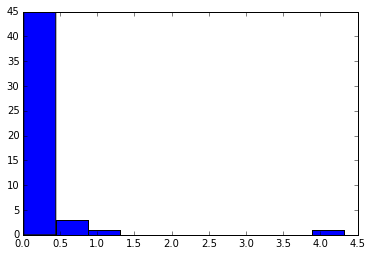

In [28]:
import matplotlib.pyplot as plt
plt.hist(perf_f[0][0])